# 2469117b Portfolio Notebook for AI for the Arts B
<a href="https://github.com/AlexanderBroad/AI_B">My Github repository</a>

## Before you try ...

- please download this zipped data file and unzip it into the same directory as this notebook: 
https://github.com/Kajiyu/ImaginarySoundscapeDemo/releases/download/v1.0.0/data.zip

## Additional Information

### References

- Imaginary Soundscape: http://imaginarysoundscape2.qosmo.jp/
- the original demo (Chrome and Firefox are only available.) : http://imaginarysoundscape.qosmo.jp/
- the original paper: https://nips2017creativity.github.io/doc/Imaginary_Soundscape.pdf


### Model
![Model](https://github.com/Kajiyu/ImaginarySoundscapeDemo/raw/master/assets/model.jpg)

### Other references
- Our model is based on MIT's SoundNet: http://soundnet.csail.mit.edu/

## Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os, sys
import shutil
import glob
import json
import collections
import tensorflow as tf
import numpy as np
import librosa
import random
from scipy.stats import entropy

import keras
from keras.models import Model, load_model
import keras.backend as K
from keras.applications.mobilenet import MobileNet
##from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from IPython.display import Audio, Image, display_jpeg, display

import librosa.display

## Function Definitions

In [2]:
def preprocess_image(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [3]:
def get_image_features(model, filepath):
    img = load_img(filepath, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_image(x)
    preds = model.predict(x)[0]
    return preds

In [4]:
def get_sound_features(model,filepath):
    x, sr = librosa.load(filepath)
    x = x * 255.0
    x = np.reshape(x, (1, x.shape[0], 1, 1))
    x[x < -255.] = -255.
    x[x > 255.] = 255.
    assert np.max(x) < 256., "It seems this audio contains signal that exceeds 256"
    assert np.min(x) > -256., "It seems this audio contains signal that exceeds -256 " + str(np.min(x)) + " : " + filepath
    _y_pred = model.predict(x)
    feature =  _y_pred[0][0][0][0]
    return feature

In [5]:
def get_topk_songs(img_feature, song_features, k=3):
    distances = []
    for i in range(len(song_features)):
        distance = entropy(img_feature, song_features[i])
        distances.append(distance)
    topk_indecies = np.argsort(distances)[:k]
    return topk_indecies

In [6]:
def create_sound_libs(
    soundnet_model,
    query="./data/sound_samples/*.mp3",
    out_json_path="./data/sounds.json",
    out_npy_path='./data/song_features.npy'
):
    mp3_files = glob.glob(query)
    output_dict = {"mp3":[]}
    for i in range(len(mp3_files)):
        x, sr = librosa.load(mp3_files[i])
        if len(x) > 230000:
            output_dict["mp3"].append({"filepath":mp3_files[i], "index":str(i)})
    with open(out_json_path, "w")  as f:
        json.dump(output_dict, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
    song_features = []
    for item in output_dict["mp3"]:
        i_feature = get_sound_features(soundnet_model,item['filepath'])
        song_features.append(i_feature)
    song_features = np.array(song_features)
    print("Sound npy shape:", song_features.shape)
    np.save(out_npy_path, song_features)
    return (output_dict, song_features)

# How to

## 1. Load SoundNet and ImageNet models

In [7]:
soundnet = load_model("./data/models/soundnet.hdf5")
imagenet = MobileNet(include_top=True, weights='imagenet') # using MobileNet

## 2. Create sound features using SoundNet model

- npy file: features of sounds pre-calculated by SoundNet
- json file: including ...
    - filepath: the path of each sound file
    - index: the index of each sound file at the npy array

In [30]:
# create sound features using SoundNet model
(mp3_files, sound_features) = create_sound_libs(soundnet)

print
print("#of mp3 files", len(mp3_files['mp3']))

1/1 [==============================] - 0s 91ms/step
Sound npy shape: (268, 1000)
#of mp3 files 268


or

In [8]:
# or, load pre-processed json data
with open("./data/sounds.json") as f:
    mp3_files = json.load(f)
sound_features = np.load("./data/song_features.npy")

## 3. Find the best-matched sound files for an input image

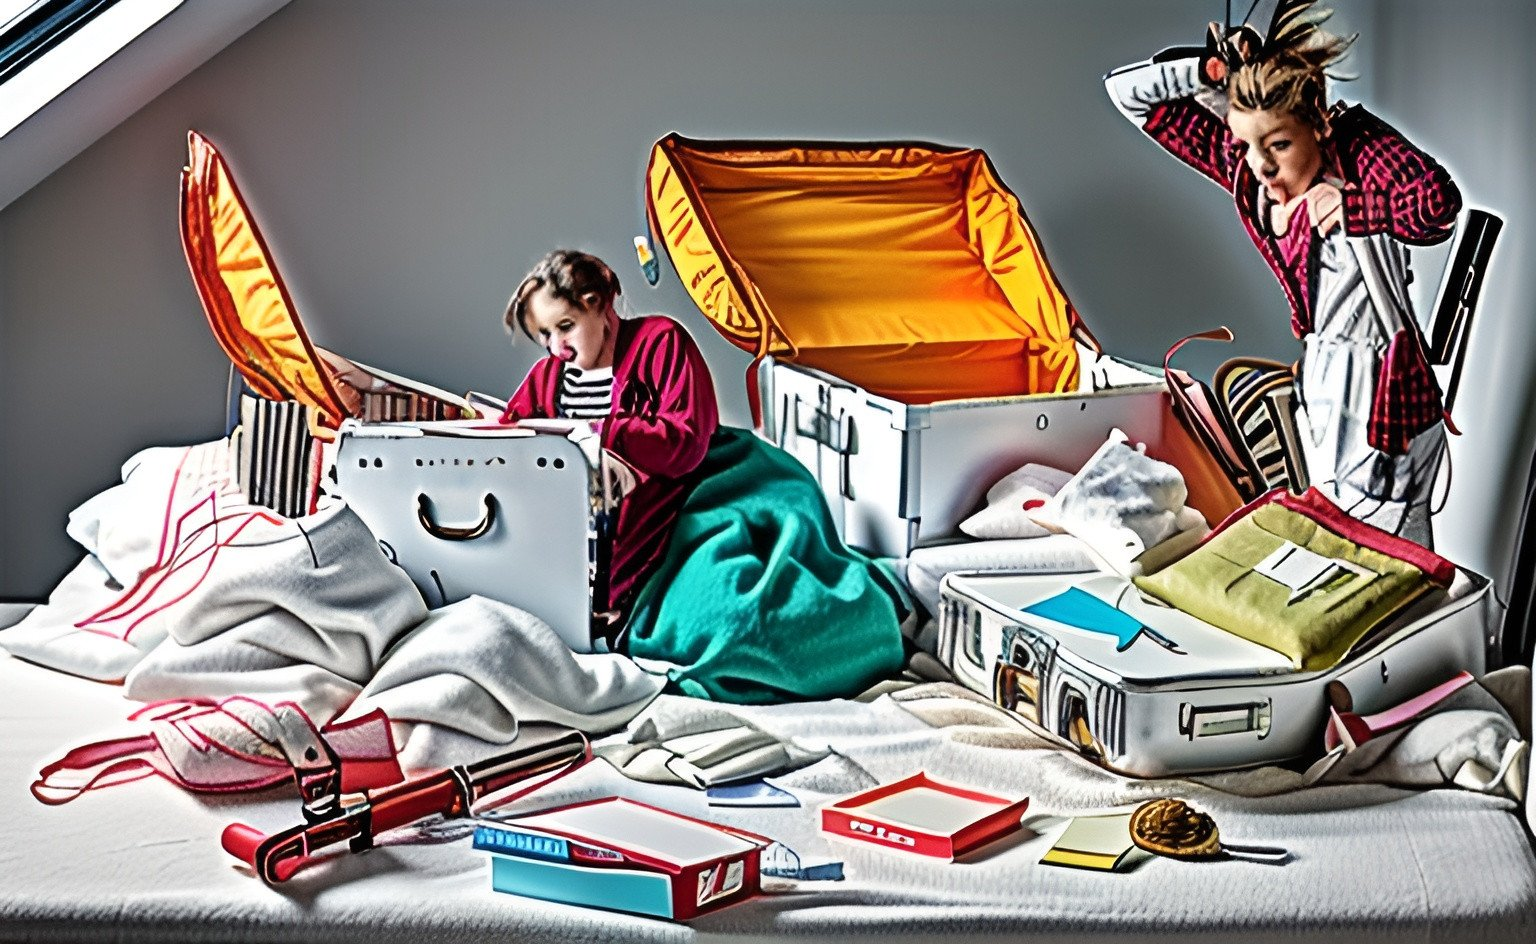

In [58]:
IMG_PATH = "./images/packing cases_upscaled.jpg"
display_jpeg(Image(IMG_PATH))

In [59]:
# Extract image features using ImageNet model(MobileNet)
img_feature = get_image_features(imagenet, IMG_PATH)

# Match the image features and pre-processed sound features,
# then find the topK best matched sound files 
topk_indecies = get_topk_songs(img_feature, sound_features, k=5)

1/1 [==============================] - 0s 29ms/step


In [60]:
print("The best-matched sound:")
print

for i in range(5):
    print("Top #", i)
    display(Audio(mp3_files["mp3"][topk_indecies[i]]["filepath"]))

The best-matched sound:
Top # 0


Top # 1


Top # 2


Top # 3


Top # 4
